# Baseline With One Electrode

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [16]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils
from brain2brain import generators
%matplotlib inline
from scipy.stats import pearsonr


# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed

In [17]:
def evaluate_naive_method(generator, n):
    batch_maes = []
    for batch_ix in range(len(generator)):
        print(f"Batch: {batch_ix}/{len(generator)}", end="\r")
        samples, targets = generator[batch_ix]
        preds = samples[:, -n:, :]
        mae = np.mean(np.abs(preds - targets), axis=(0, 1))
        batch_maes.append(mae)
    means = np.mean(batch_maes, axis=0)
    print(means)
    print(means.shape)
    return means

def evaluate_naive_method_pearson_r_batch_ix(generator, n, batch_ix):
    electrodes_r = np.empty(shape=(generator[0][0].shape[2],))
    electrodes_mae = np.empty(shape=(generator[0][0].shape[2],))
    
    samples, targets = generator[batch_ix]
    preds = samples[:, -n:, :]
    for electrode in range(samples.shape[2]):
        electrode_r = np.empty(shape=(samples.shape[0],))
        sample_maes = np.empty(shape=(samples.shape[0],))
        z_array = np.empty(shape=(samples.shape[0],))
        for sample_ix in range(samples.shape[0]):
            r, p = pearsonr(targets[sample_ix, :, electrode], preds[sample_ix, :, electrode])
            electrode_r[sample_ix] = r
            z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
            mae = np.mean(np.abs(targets[sample_ix, :, electrode] - preds[sample_ix, :, electrode]))
            sample_maes[sample_ix] = mae
        z_mean = np.mean(z_array)
        batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
        batch_mae = np.mean(sample_maes)
        print(f"E{electrode}: Batch_r: {batch_r}")
        print(f"E{electrode}: Absolute Batch_r: {np.mean(np.abs(electrode_r))}")
        print(f"E{electrode}: Batch Mae: {batch_mae}")
        electrodes_mae[electrode] = batch_mae
        electrodes_r[electrode] = batch_r
    return electrodes_mae, electrodes_r

In [18]:
def evaluate_naive_method_pearson_r_batch_ix_ele(generator, n, batch_ix, electrode):
    samples, targets = generator[batch_ix]
    preds = samples[:, -n:, :]

    electrode_r = np.empty(shape=(samples.shape[0],))
    sample_maes = np.empty(shape=(samples.shape[0],))
    z_array = np.empty(shape=(samples.shape[0],))
    for sample_ix in range(samples.shape[0]):
        r, p = pearsonr(targets[sample_ix, :, electrode], preds[sample_ix, :, electrode])
        electrode_r[sample_ix] = r
        z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
        mae = np.mean(np.abs(targets[sample_ix, :, electrode] - preds[sample_ix, :, electrode]))
        sample_maes[sample_ix] = mae
    z_mean = np.mean(z_array)
    batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
    batch_mae = np.mean(sample_maes)
    print(f"E{electrode}: Batch_r: {batch_r}")
    print(f"E{electrode}: Absolute Batch_r: {np.mean(np.abs(electrode_r))}")
    print(f"E{electrode}: Batch Mae: {batch_mae}")
    return sample_maes, electrode_r

# Normalized Data

In [5]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_norm_2.txt")
# Split the train files into a training and validation set.
electrode_count = 1
target_electrode = list(range(114))
# Training Generator
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=128,
                                        length=25,
                                        delay=0,
                                        batch_size=20000,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=128,
                                        length=25,
                                        delay=0,
                                        batch_size=5000,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=False)

In [6]:
evaluate_naive_method_pearson_r_batch_ix(val_generator, n, batch_ix):

SyntaxError: invalid syntax (<ipython-input-6-c15a978489a2>, line 1)

In [44]:
all_means = evaluate_naive_method(val_generator, 25, 0)

[0.92094281 0.90396624 0.87652345 0.91628701 0.92378321 0.73271785
 0.93467924 0.77346857 0.85017777 0.91893609 0.91676742 0.95594761
 0.96590153 0.89775711 0.86394898 0.86499514 0.92532291 0.93862288
 0.98998062 0.98114797 0.87280384 0.95234144 0.97890112 0.95797464
 0.81936904 0.86586875 0.95893599 0.9746798  1.02128751 0.9690825
 0.97020559 0.93803388 0.83032036 0.82026648 0.9344264  0.87611643
 0.90067495 0.92719329 0.95979492 0.9342538  0.77356563 0.94162474
 0.97833054 0.97444311 0.84965593 0.90504876 0.94523852 0.85805291
 0.76416054 0.94328131 0.95589407 0.98517418 0.97218192 0.94295099
 0.96064925 0.82293418 0.7168084  0.89327722 0.97182128 0.93827948
 0.94849974 0.94592173 0.96110015 0.95079499 0.63854901 0.70894073
 0.73593943 0.90559188 0.75951015 0.77539137 0.81272353 0.94783753
 0.96472243 0.98673694 0.98534138 0.95427988 0.9359955  0.85727954
 0.89714814 0.8898966  0.85674658 0.86647209 0.9309562  0.79594256
 0.90085054 0.91630582 0.89939296 0.88600934 0.87120047 0.85527

In [60]:
min(all_means)

0.6385490105741648

In [63]:
all_means.argmin()

64

In [64]:
all_means[64]

0.6385490105741648

In [20]:
all_r = evaluate_naive_method_pearson_r_batch_ix(val_generator, 25, 0)

Electrode 0 r: -0.28087440461372487
Electrode 1 r: -0.27801086417399834
Electrode 2 r: -0.27938347879912534
Electrode 3 r: -0.2820147446847488
Electrode 4 r: -0.2911146419710917
Electrode 5 r: -0.28576712883715955
Electrode 6 r: -0.26133758506765203
Electrode 7 r: -0.28242741352280193
Electrode 8 r: -0.27947283995915745
Electrode 9 r: -0.2885123607954166
Electrode 10 r: -0.2870982155346996
Electrode 11 r: -0.29402412801068045
Electrode 12 r: -0.2795294182189781
Electrode 13 r: -0.29263282358613746
Electrode 14 r: -0.2951507022702356
Electrode 15 r: -0.29370110597696203
Electrode 16 r: -0.2925088183593717
Electrode 17 r: -0.28587195617833183
Electrode 18 r: -0.28218343620749275
Electrode 19 r: -0.298393390372902
Electrode 20 r: -0.2896997565623149
Electrode 21 r: -0.29441284981838095
Electrode 22 r: -0.31877437876895026
Electrode 23 r: -0.3119600861279763
Electrode 24 r: -0.2900666412000216
Electrode 25 r: -0.293908264913363
Electrode 26 r: -0.28409460093228645
Electrode 27 r: -0.281458

# Binned Data

In [7]:
train_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
# Split the train files into a training and validation set.
electrode_count = 1
target_electrode = list(range(114))
# Training Generator
train_bin_norm_generator = generators.FGenerator(file_paths=train_bin_norm_paths,
                                        lookback=100,
                                        length=20,
                                        delay=0,
                                        batch_size=2048,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=True)
# Validation Generator
val_bin_norm_generator = generators.FGenerator(file_paths=val_bin_norm_paths,
                                        lookback=100,
                                        length=20,
                                        delay=0,
                                        batch_size=4000,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=False)

In [8]:
encoder_input_data = val_bin_norm_generator

In [9]:
len(val_bin_norm_generator)

1

In [10]:
test_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/test_676_bin_norm_2.txt")
test_bin_norm_generator = generators.FGenerator(file_paths=test_bin_norm_paths,
                                        lookback=100,
                                        length=20,
                                        delay=0,
                                        batch_size=4000,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=False)

In [11]:
mae, r = evaluate_naive_method_pearson_r_batch_ix_ele(val_bin_norm_generator, 20, 0, 5)

E5: Batch_r: -0.022707018124865412
E5: Absolute Batch_r: 0.21818305415728714
E5: Batch Mae: 0.8179204000752345


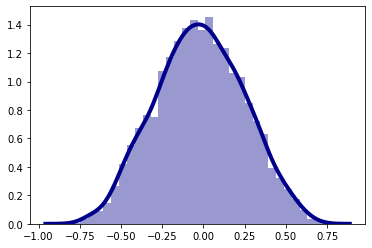

In [12]:
# Plot the distribution of r
import seaborn as sns
sns.distplot(r, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [10]:
mae, r = evaluate_naive_method_pearson_r_batch_ix_ele(test_bin_norm_generator, 20, 0, 5)

E5: Batch_r: -0.030926120078439815
E5: Absolute Batch_r: 0.226197863448109
E5: Batch Mae: 0.8632069622860908


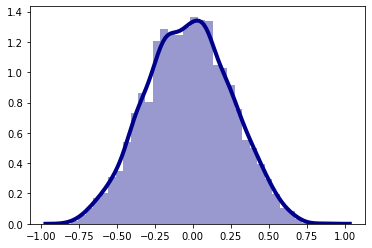

In [22]:
# Plot the distribution of r
import seaborn as sns
sns.distplot(r, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [27]:
def test_input_seq(input_seq,
                   lookback,
                   pred_length,
                   electrode,
                   verbose=True):
    input_seq = input_seq[:, electrode]
    input_seq = input_seq.reshape((input_seq.shape[0], 1))
    # Window prediction
    w_start = 0
    w_end = w_start + lookback
    final_array = np.empty(shape=(input_seq.shape[0], 1))
    final_array[w_start : w_end, :] = input_seq[w_start : w_end, :]
    print(final_array.shape)
    while w_end + pred_length < input_seq.shape[0]:
        window_lookback = np.array(input_seq[-pred_length:])
        final_array[w_end:w_end+pred_length] = window_lookback.reshape((pred_length, 1))
#         print(final_array[w_end:w_end+pred_length] ==  window_lookback)
        w_end += pred_length
        w_start += pred_length
    predicted_series = final_array
    input_seq = input_seq[lookback:,:]
    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae
    
    print(f"Val MAE = {mae}")
    return mae, r

In [42]:
data = np.load(val_bin_norm_paths[0])

(1100, 1)
Correlation: 0.005957599168515729. P: 0.8507497642282703. MAE: 0.8713362353517662


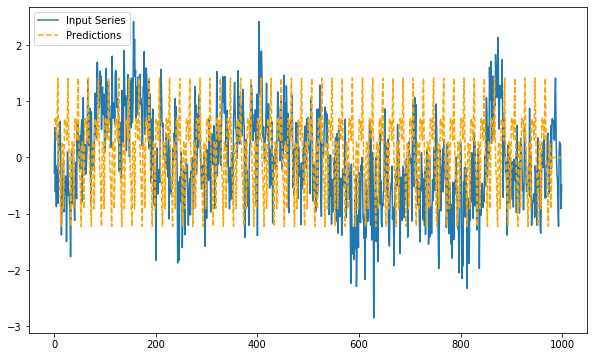

In [44]:
mae, r = test_input_seq(data[:1100], 100, 20, 5)

In [28]:
data = np.load(test_bin_norm_paths[0])

(1000, 1)
Correlation: -0.014282056434321951. P: 0.6687326278023329. MAE: 0.8252622589359342


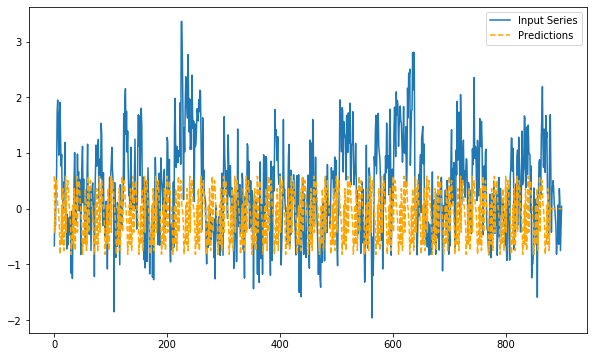

In [40]:
mae, r = test_input_seq(data[:1100], 100, 20, 5)

In [14]:
mae, r = evaluate_naive_method_pearson_r_batch_ix(val_bin_norm_generator, 20, 0)

E0: Batch_r: -0.009586839352145089
E0: Absolute Batch_r: 0.20858950204686222
E0: Batch Mae: 0.9239059226060291
E1: Batch_r: -0.01776063898837057
E1: Absolute Batch_r: 0.21710997530462567
E1: Batch Mae: 0.9170137234291204
E2: Batch_r: -0.011795785001188724
E2: Absolute Batch_r: 0.21415610189648557
E2: Batch Mae: 0.8935268532967724
E3: Batch_r: 0.00011994028095395107
E3: Absolute Batch_r: 0.20402667202879898
E3: Batch Mae: 0.9081721825790934
E4: Batch_r: -0.00872516835390417
E4: Absolute Batch_r: 0.20623208453030398
E4: Batch Mae: 0.8963630708107612
E5: Batch_r: -0.022707018124865412
E5: Absolute Batch_r: 0.21818305415728714
E5: Batch Mae: 0.8179204000752345
E6: Batch_r: -0.007157526332339744
E6: Absolute Batch_r: 0.2066674286793555
E6: Batch Mae: 0.8818061699923982
E7: Batch_r: -0.007987477581751883
E7: Absolute Batch_r: 0.21217820727159373
E7: Batch Mae: 0.8093108748555762
E8: Batch_r: -0.02249440204732478
E8: Absolute Batch_r: 0.21987518431376457
E8: Batch Mae: 0.9202385806098887
E9: 

In [ ]:
all_bin_norm_r, all_bin = evaluate_naive_method(val_bin_norm_generator, 10)

In [14]:
min(all_bin_norm_means)

0.7610558624187624

In [15]:
np.mean(all_bin_norm_means)

0.8774896946086416

In [16]:
all_bin_norm_means.argmin()

5

In [15]:
k = 10
result = np.argsort(mae)[:k]
print("\nk smallest values:")
for i in range(k):
    print(f"Electrode {result[i]}, mae={mae[result[i]]}; r= {r[result[i]]}")


k smallest values:
Electrode 7, mae=0.8093108748555762; r= -0.007987477581751883
Electrode 5, mae=0.8179204000752345; r= -0.022707018124865412
Electrode 103, mae=0.8244068986776205; r= -0.004385144636076459
Electrode 107, mae=0.8293257324988665; r= -0.008917702044989732
Electrode 15, mae=0.8371903746599677; r= -0.011055909310805908
Electrode 94, mae=0.8374192334273516; r= -0.0066371921630746025
Electrode 25, mae=0.8419396471688277; r= -0.009943522757930801
Electrode 108, mae=0.8429687535969709; r= -0.006100449923370005
Electrode 99, mae=0.8490289971301798; r= -0.004371812449300118
Electrode 20, mae=0.8528244500965466; r= -0.016059101318719907


In [20]:
all_bin_norm_r = evaluate_naive_method_pearson_r_batch_ix(val_bin_norm_generator, 10, 0)

Electrode 0 r: -0.016681162882779713
Electrode 1 r: -0.022980811796146427
Electrode 2 r: -0.020210789894819763
Electrode 3 r: -0.009237302861552221
Electrode 4 r: -0.014327131793349759
Electrode 5 r: -0.026301412393507875
Electrode 6 r: -0.01689635166847336
Electrode 7 r: -0.02173729063400303
Electrode 8 r: -0.028119082262215506
Electrode 9 r: -0.022456930307229145
Electrode 10 r: -0.0279531120740867
Electrode 11 r: 0.0019483978146551883
Electrode 12 r: -0.0071525388141292275
Electrode 13 r: -0.0077983840429339665
Electrode 14 r: -0.003949838532377589
Electrode 15 r: -0.024785472320041715
Electrode 16 r: -0.02861643477052715
Electrode 17 r: -0.021454450589494172
Electrode 18 r: -0.005962366913164003
Electrode 19 r: 0.0004983140371251415
Electrode 20 r: -0.01699539567790267
Electrode 21 r: -0.008648214299611885
Electrode 22 r: -0.017712047655279436
Electrode 23 r: -0.022976173833836742
Electrode 24 r: -0.017329367796258602
Electrode 25 r: -0.01917232225684943
Electrode 26 r: -0.00238060

In [23]:
all_bin_norm_r.argmin()

70

In [25]:
all_bin_norm_r[70]

-0.03441815208092012

In [28]:
k = 10
result = np.argpartition(all_bin_norm_r, k)
print("\nk smallest values:")
for i in range(k):
    print(f"Electrode {result[i]}, r={all_bin_norm_r[result[k]]}")


k smallest values:
Electrode 8, r=-0.026019538456865048
Electrode 70, r=-0.026019538456865048
Electrode 16, r=-0.026019538456865048
Electrode 36, r=-0.026019538456865048
Electrode 79, r=-0.026019538456865048
Electrode 44, r=-0.026019538456865048
Electrode 10, r=-0.026019538456865048
Electrode 29, r=-0.026019538456865048
Electrode 55, r=-0.026019538456865048
Electrode 5, r=-0.026019538456865048


(4000,)

k biggest values:
Sample 1796, mae:1.920013224899689, r:(-0.3001395025159689, 0.19853878954519374)
Sample 3499, mae:1.9281854593955796, r:(-0.43817970595233946, 0.053305295468714625)
Sample 1696, mae:1.9614050853628193, r:(0.014862473276482463, 0.9504112858214849)
Sample 2865, mae:2.1681398626312554, r:(-0.21471716259050083, 0.3633067825611306)
Sample 2043, mae:2.219434071354878, r:(0.09835004403538145, 0.6799607590114202)
Sample 2591, mae:2.6431708090847588, r:(0.48706781256416676, 0.02939941730881133)
Sample 2500, mae:2.822640043266339, r:(0.28493127382593064, 0.22336018453738268)
Sample 2492, mae:3.200419252526145, r:(-0.43030730426126373, 0.05824526342291827)
Sample 2497, mae:5.118560539663568, r:(0.6517463823157498, 0.00184875088437077)
Sample 3847, mae:5.1224531372857, r:(0.04547227744634462, 0.8490255806659552)
Sample 3841, mae:5.163047531872552, r:(0.2881653944368394, 0.2179197963679719)
Sample 3870, mae:5.745848596954576, r:(-0.09259582717081988, 0.6978137539483135)
S

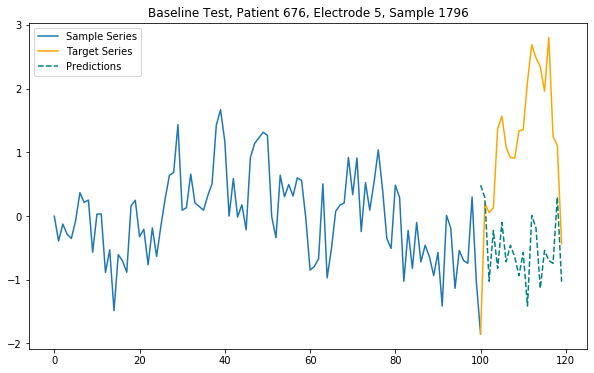

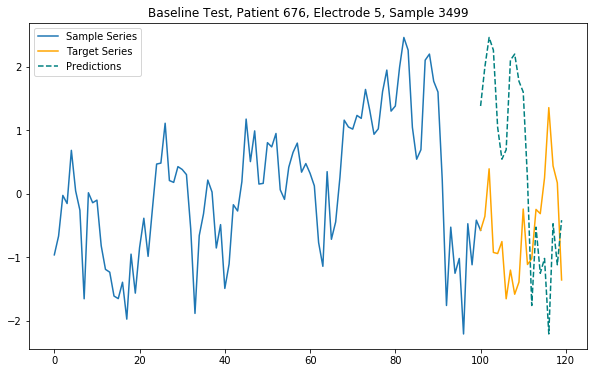

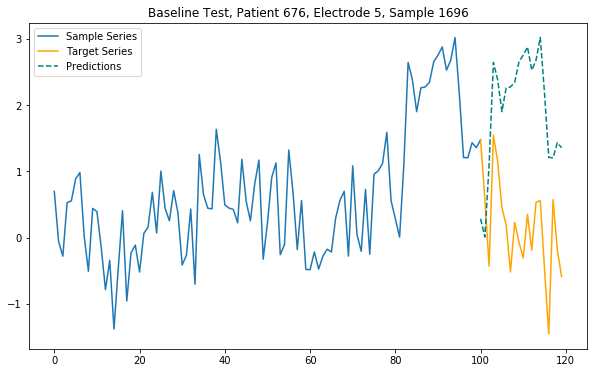

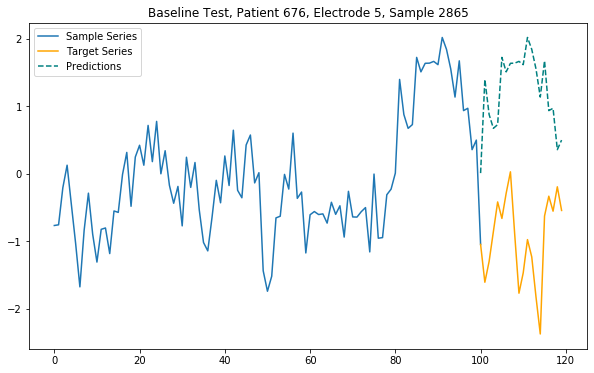

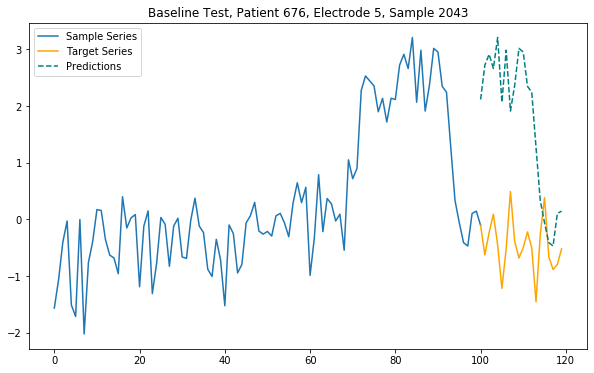

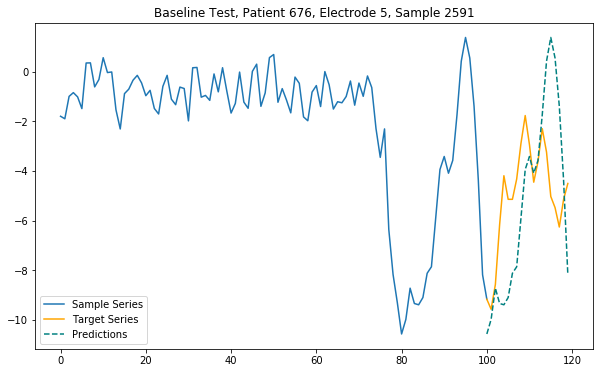

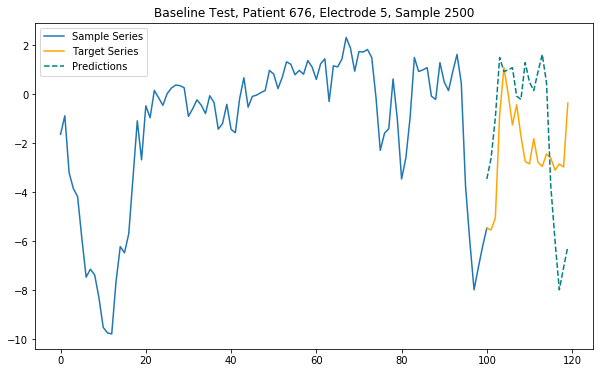

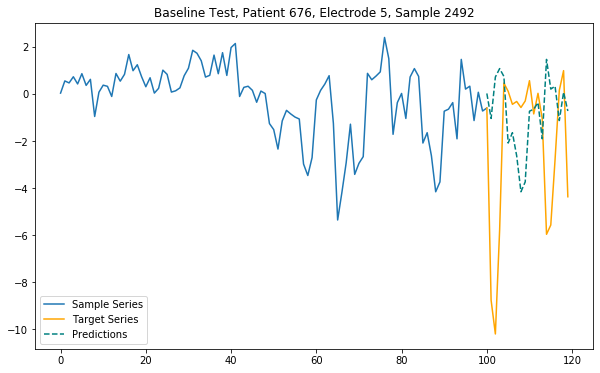

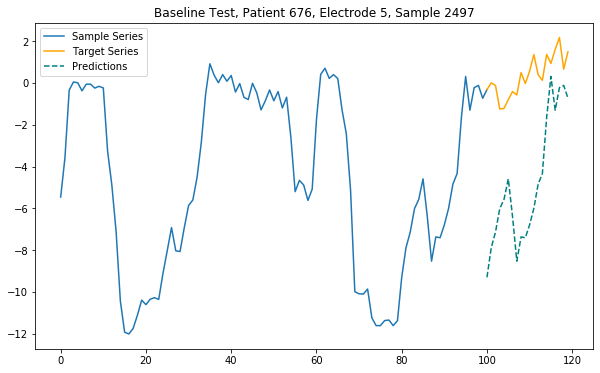

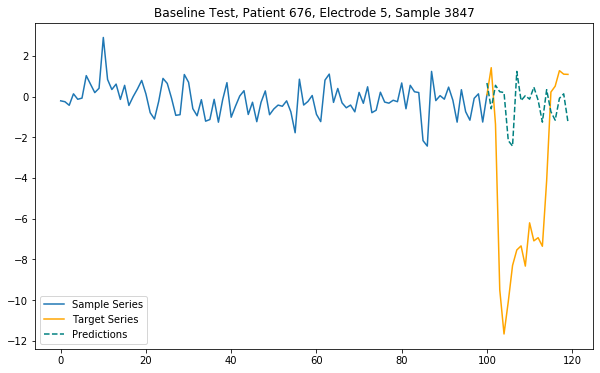

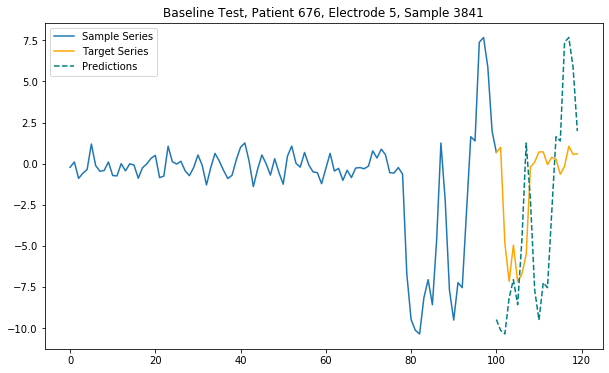

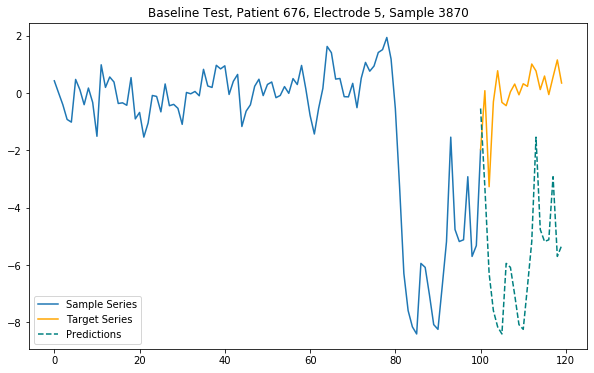

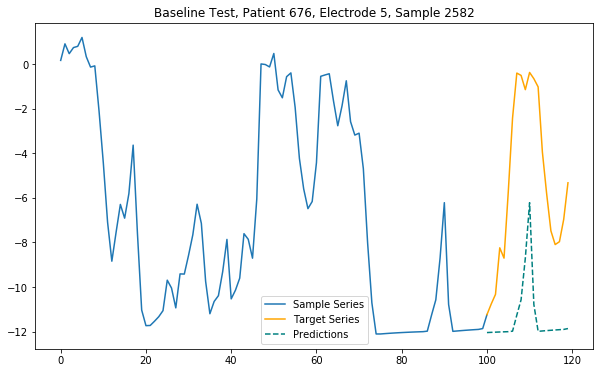

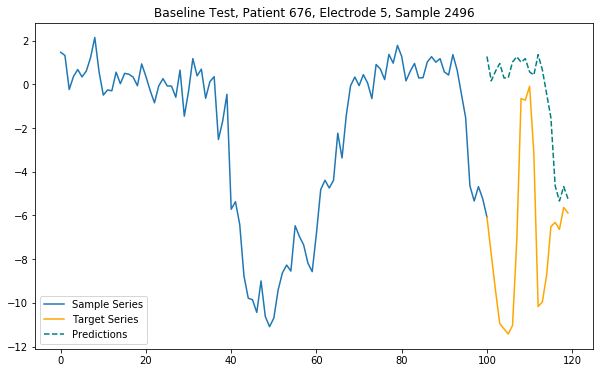

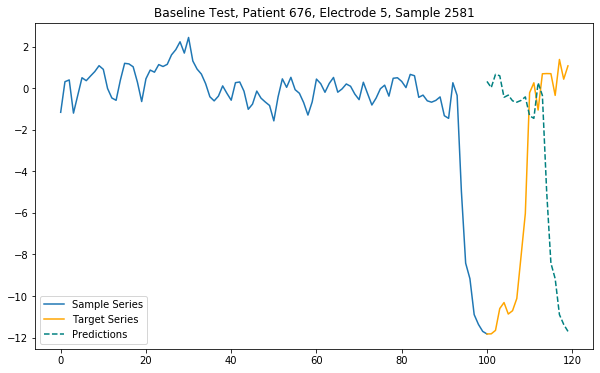

In [28]:
# Show Electrode 5
electrode = 5
n = 20
samples, targets = val_bin_norm_generator[0]
preds = samples[:, -n:, electrode]
mae_per_sample = np.mean(np.abs(targets[:, :, electrode] - preds), axis=1)
print(mae_per_sample.shape)
k = 15
result = mae_per_sample.argsort()[-k:]
print("\nk biggest values:")
for i in range(k):
    print(f"Sample {result[i]}, mae:{mae_per_sample[result[i]]}, r:{pearsonr(targets[result[i], :, electrode],preds[result[i],:])}")
    plt.figure(figsize=(10,6))   
    x_sample = samples[result[i], :, electrode].shape[0]
    sample=np.concatenate([samples[result[i],:, electrode], targets[result[i], :1, electrode]])
    plt.plot(range(0,x_sample+1), sample)
    plt.plot(range(x_sample,x_sample+n),targets[result[i], :, electrode], color='orange')
    plt.plot(range(x_sample,x_sample+n),preds[result[i],:], color='teal', linestyle='--')
    plt.title(f'Baseline Test, Patient 676, Electrode {electrode}, Sample {result[i]}')
    plt.legend(['Sample Series','Target Series','Predictions'])